# Running the Kalibr multicam dataset

This notebook demonstrates the calibration of a stereo pair using the [5-parameter OpenCV camera model](https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html). We use the Kalibr multi-camera calibration dataset. Data can be found [here](https://github.com/ethz-asl/kalibr/wiki/downloads).

In [32]:
# Some pre-requisites we need to import
import os

import calico
import cv_bridge
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.transform import Rotation as R
from sensor_msgs.msg import Image
import rosbag

bridge = cv_bridge.CvBridge()

# Parse data

We start by parsing the data. Kalibr uses an in-house visual fiducial called [Aprilgrid](https://github.com/ethz-asl/kalibr/wiki/calibration-targets). Calico comes with an Aprilgrid detector along with python bindings.

Here, we go through every image in the rosbag, run an Aprilgrid detection, then store those detections in a dictionary.

In [33]:
# Read in the rosbag and create an Aprilgrid chart detector.
bag_path = '/home/james/Downloads/multicamera-calibration-data/cam_april.bag'
bag = rosbag.Bag(bag_path, 'r')
chart_definition_path = (
'/home/james/Downloads/multicamera-calibration-data/april_6x6.yaml')
detector = calico.AprilGridDetector(chart_definition_path)


# Extract Aprilgrid detections from images.
topic_left = '/cam0/image_raw'
topic_right = '/cam1/image_raw'
all_detections = {
    topic_left: [],
    topic_right: [],
}
all_images = {
    topic_left: {},
    topic_right: {},
}
total_expected_messages = \
    bag.get_message_count(topic_left) + bag.get_message_count(topic_right)
msg_count = 0
sample_image = None
for topic, msg, stamp in bag.read_messages(topics = [topic_left, topic_right]):
    msg_count += 1
    print(f'\r{(100.0 * msg_count) / total_expected_messages:.1f}%:'
          f' Processed {msg_count} of {total_expected_messages} images.', end='')
    cv_img = bridge.imgmsg_to_cv2(msg, desired_encoding = 'passthrough')
    all_images[topic][msg.header.seq] = cv_img.copy()
    detections = detector.Detect(cv_img)
    if len(detections) < 28:
      continue
    all_detections[topic].append(
        (msg.header.stamp.to_sec(), msg.header.seq, detections))
    # Nab the "middle" image just for visualization purposes.
    if msg_count == total_expected_messages // 2:
        sample_image = calico.DrawDetections(cv_img, detections)
bag.close()

#plt.figure()
#plt.imshow(sample_image)

100.0%: Processed 2899 of 2899 images.

# Create `WorldModel`

We need the physical definitions of the fiducial corners. In this case, we grab the model definition from the detector and get it as a `RigidBody`. `WorldModel` is capable of holding multiple `RigidBody` definitions, but our problem only has one, i.e. the Aprilgrid chart.

In [34]:
chart_rigid_body = detector.GetRigidBodyDefinition()
chart_rigid_body.world_pose_is_constant = True
chart_rigid_body.model_definition_is_constant = True
world_model = calico.WorldModel()
world_model.AddRigidBody(chart_rigid_body)

# Create `Camera`'s
Next, we populate camera objects with the appropriate information. Given the current set of detections, we obtain a ballpark guess at each camera's pinhole parameters. This guess will be used to initialize the intrinsics parameters.

In [35]:
# Estimate the pinhole parameters for the left and right cameras. Also estimate
# the left camera's trajectory with respect to the chart.
left_detections = [detections[2] for detections in all_detections[topic_left]]
intrinsics_left, R_chart_left, t_chart_left = calico.InitializePinholeAndPoses(
    left_detections, chart_rigid_body.model_definition)
right_detections = [detections[2] for detections in all_detections[topic_right]]
intrinsics_right, _, _ = calico.InitializePinholeAndPoses(
    right_detections, chart_rigid_body.model_definition)

# Parse the estimated intrinsics and average them since the cameras are similar.
# We are initializing with the 5-parameter OpenCV distortion model with an
# isotropic focal length and no skew, i.e.
# K = [f 0 cx]
#     [0 f cy]
#     [0 0  1]
f = np.mean([
intrinsics_left[0], intrinsics_left[1],
intrinsics_right[0], intrinsics_right[1]])
cx = np.mean([intrinsics_left[3], intrinsics_right[3]])
cy = np.mean([intrinsics_left[4], intrinsics_right[4]])
initial_intrinsics = [f, cx, cy, 0, 0, 0, 0, 0]

# Create our camera objects and populate their information.
camera_left = calico.Camera()
camera_left.SetName(topic_left)
for stamp, seq, detections in all_detections[topic_left]:
    measurements = calico.DetectionsToCameraMeasurements(detections, stamp, seq)
    camera_left.AddMeasurements(measurements)
camera_left.SetModel(calico.CameraIntrinsicsModel.kOpenCv5)
camera_left.SetIntrinsics(initial_intrinsics)

camera_right = calico.Camera()
camera_right.SetName(topic_right)
for stamp, seq, detections in all_detections[topic_right]:
    measurements = calico.DetectionsToCameraMeasurements(detections, stamp, seq)
    camera_right.AddMeasurements(measurements)
camera_right.SetModel(calico.CameraIntrinsicsModel.kOpenCv5)
camera_right.SetIntrinsics(initial_intrinsics)

# Create Sensor Rig `Trajectory`

Initializing the pinhole parameters for the left camera also provided us with its pose relative to the calibration chart. We model this problem as a camera moving in front of a stationary chart, and use those camera poses directly in the construction of our `Trajectory` object.

In [36]:
stamps = [detections[0] for detections in all_detections[topic_left]]
poses_chart_sensorrig = {}
for stamp, R_chart_left_i, t_chart_left_i in\
  zip(stamps, R_chart_left, t_chart_left):
    pose_chart_sensorrig = calico.Pose3d()
    pose_chart_sensorrig.rotation = \
      R.from_matrix(R_chart_left_i).as_quat()[[3, 0, 1, 2]]
    pose_chart_sensorrig.translation = t_chart_left_i
    poses_chart_sensorrig[stamp] = pose_chart_sensorrig
trajectory_chart_sensorrig = calico.Trajectory()
trajectory_chart_sensorrig.AddPoses(poses_chart_sensorrig)

# Calibrate!

We're done setting up our problem! Now we create a `BatchOptimizer` object, add the `WorldModel`, `Trajectory`, and `Camera` objects to the optimizer, and run an optimization to completion.

In [37]:
# Print our intrinsics and extrinsics prior to optimization.
print('---------------------------------------------------------')
print('Intial intrinsics: ')
print(f'{camera_left.GetName()}: {camera_left.GetIntrinsics()}')
print(f'{camera_right.GetName()}: {camera_right.GetIntrinsics()}')
print('Initial extrinsics: ')
print(f'{camera_right.GetName()}: q - {camera_right.GetExtrinsics().rotation}, t - {camera_right.GetExtrinsics().translation}')

# Configure the sensors for estimation.
camera_left.EnableIntrinsicsEstimation(True)
camera_left.EnableExtrinsicsEstimation(False)
camera_left.EnableLatencyEstimation(False)
camera_right.EnableIntrinsicsEstimation(True)
camera_right.EnableExtrinsicsEstimation(True)
camera_right.EnableLatencyEstimation(True)

# Create optimizer and add everything
optimizer = calico.BatchOptimizer()
optimizer.AddSensor(camera_left)
optimizer.AddSensor(camera_right)
optimizer.AddWorldModel(world_model)
optimizer.AddTrajectory(trajectory_chart_sensorrig)

# Configure solver and run optimization.
options = calico.DefaultSolverOptions()
options.num_threads = 4
options.minimizer_progress_to_stdout = False
summary = optimizer.Optimize(options)

# Print results.
print('---------------------------------------------------------')
print('Final intrinsics: ')
print(f'{camera_left.GetName()}: {camera_left.GetIntrinsics()}')
print(f'{camera_right.GetName()}: {camera_right.GetIntrinsics()}')
print('Final extrinsics: ')
print(f'{camera_right.GetName()}: q - {camera_right.GetExtrinsics().rotation}, t - {camera_right.GetExtrinsics().translation}')
print(f'Final latency: {camera_right.GetLatency()}')
print('---------------------------------------------------------')
print('Final RMSE')
print(np.sqrt(summary.final_cost / summary.num_residuals))

---------------------------------------------------------
Intial intrinsics: 
/cam0/image_raw: [593.33275266 350.01289069 204.33745359   0.           0.
   0.           0.           0.        ]
/cam1/image_raw: [593.33275266 350.01289069 204.33745359   0.           0.
   0.           0.           0.        ]
Initial extrinsics: 
/cam1/image_raw: q - [1. 0. 0. 0.], t - [0. 0. 0.]
---------------------------------------------------------
Final intrinsics: 
/cam0/image_raw: [ 4.57599095e+02  3.67040411e+02  2.49518383e+02 -3.01916210e-01
  1.14594906e-01  5.37976881e-05 -1.26860180e-04 -2.22649989e-02]
/cam1/image_raw: [ 4.56426096e+02  3.80034525e+02  2.56552170e+02 -2.99967367e-01
  1.12022573e-01 -2.00380569e-04 -1.75287149e-04 -2.14172466e-02]
Final extrinsics: 
/cam1/image_raw: q - [9.99975687e-01 6.88663332e-03 1.44525241e-04 1.08604663e-03], t - [ 0.11020942 -0.00021809  0.00051389]
Final latency: -4.9477944063656576e-05
---------------------------------------------------------
Fin

# First impressions
Our preliminary results yield an RMSE of 0.24 pixels. A perfect calibration should yield an RMSE on the order of pixel noise which is between 0.05 and 0.1 pixels.

Generally speaking, a sub-pixel calibration is considered "passing", but this error is not ideal. Let's dive a little deeper to see what's wrong.

# Identifying larger residuals
In the next step, we parse the measurements and residuals from the left camera and attempt to identify any timestamps that have high residuals.

Largest error on image 7910


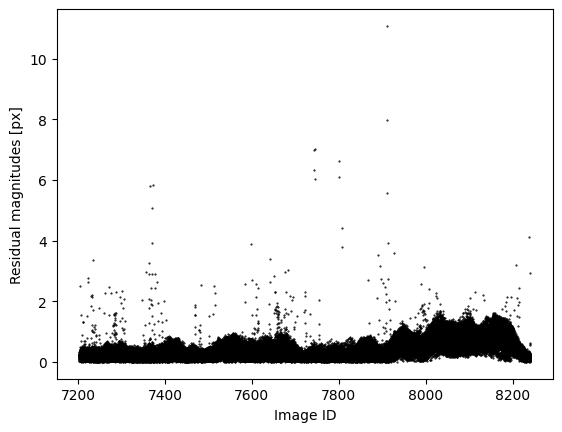

In [38]:
# Grab residuals and measurements.
from collections import defaultdict

measurement_id_to_residual = camera_left.GetMeasurementIdToResidual()
image_id_to_residuals = defaultdict(list)
for m_id, residual in measurement_id_to_residual.items():
    image_id_to_residuals[m_id.image_id].append(np.linalg.norm(residual))

plt.close('all')
plt.figure()
max_error = -float('inf')
max_error_image_id = -1
for image_id, errors in image_id_to_residuals.items():
    temp = max(errors)
    if temp > max_error:
        max_error = temp
        max_error_image_id = image_id
    plt.plot([image_id] * len(errors), errors, 'k.', markersize=1)
plt.xlabel('Image ID')
plt.ylabel('Residual magnitudes [px]')
print(f'Largest error on image {max_error_image_id}')

# Finding patterns in the data
As you can see from the plot above, many frames have residuals more than 2 pixels with one reaching over 10.

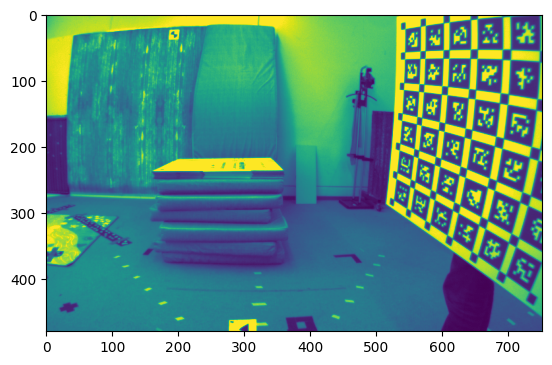

In [39]:
plt.figure()
plt.imshow(all_images[topic_left][max_error_image_id])
#measurement_residual_pairs = camera_left.GetMeasurementResidualPairs()